# Data cleaning and merge for FEDEARROZ

## precipitation
se obtiene un dataframe con data diaria (eventos de lluvia)

In [1]:
import pandas as pd
import numpy as np
#==================================

import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
gcs_path = 'gs://datalake-fedearroz/zone=landing/source=estaciones-davis/fedearroz_datos-diarios-climaticos_20240816.parquet'
catalogo = 'gs://datalake-fedearroz/zone=landing/source=estaciones-davis/fedearroz_catalogo-estaciones_20240816.xlsx'

In [3]:
stations = pd.read_parquet(gcs_path, engine='pyarrow')
cat= pd.read_excel(catalogo)
cat.head()


,st_name,LAT,LON,st_state,st_municipality
0,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA
1,FEDEARROZ_VALLEDUPAR_LA_ESPERANZA,10.48792,-73.18527,CESAR,VALLEDUPAR
2,FEDEARROZ_ACHI_LA_MANO_DE_DIOS,8.57167,-74.55601,BOLIVAR,ACHI
3,FEDEARROZ_AGUAZUL_EL_CUSIANA,4.97763,-72.61643,CASANARE,TAURAMENA
4,FEDEARROZ_AGUAZUL_EL_PALMAR,5.13960,-72.50129,CASANARE,AGUAZUL


### columnas sobre lluvia

In [4]:
stations[['date', 'minutes_covered', 'rain_amount_clicks', 'rain_rate_clicks', 'rain_amount', 'rain_rate',
       'station']].head()

,date,minutes_covered,rain_amount_clicks,rain_rate_clicks,rain_amount,rain_rate,station
0,2015-07-06,360.0,0.0,0.0,0.0,0.0,BARRANCA_DE_UPIA
1,2015-07-07,540.0,0.0,0.0,0.0,0.0,BARRANCA_DE_UPIA
2,2015-07-08,NaN,NaN,NaN,NaN,NaN,BARRANCA_DE_UPIA
3,2015-07-09,NaN,NaN,NaN,NaN,NaN,BARRANCA_DE_UPIA
4,2015-07-10,NaN,NaN,NaN,NaN,NaN,BARRANCA_DE_UPIA


In [5]:
precipitation= stations[['date',  'rain_amount',  'station']]
precipitation['date'] = pd.to_datetime(precipitation['date'])

/var/tmp/ipykernel_10681/681714097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation['date'] = pd.to_datetime(precipitation['date'])


### cruce con lat/long

las estaciones ue no aparecen es por problemas sintacticos, se cambiara... se hizo el merge y quita sueño por la ñ tenia error por ejemplo

In [6]:
stations[stations['station'].str.contains('QUI')][['date', 'minutes_covered', 'rain_amount_clicks', 'rain_rate_clicks', 'rain_amount', 'rain_rate',
       'station']].head()

,date,minutes_covered,rain_amount_clicks,rain_rate_clicks,rain_amount,rain_rate,station
50712,2011-09-19,10.0,0.0,0.0,0.0,0.0,FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS
50713,2011-09-20,120.0,0.0,0.0,0.0,0.0,FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS
50714,2011-09-21,110.0,0.0,0.0,0.0,0.0,FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS
50715,2011-09-22,85.0,0.0,0.0,0.0,0.0,FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS
50716,2011-09-23,55.0,0.0,0.0,0.0,0.0,FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS


In [7]:
precipitation.shape

(163822, 3)

In [8]:
cat['st_name']=cat['st_name'].replace('FEDEARROZ_GUAMO_QUITA_SUEÃƒâ€˜OS', 'FEDEARROZ_GUAMO_QUITA_SUENOS')
precipitation['station']=precipitation['station'].replace('FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS', 'FEDEARROZ_GUAMO_QUITA_SUENOS')

/var/tmp/ipykernel_10681/4263975556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation['station']=precipitation['station'].replace('FEDEARROZ_GUAMO_QUITA_SUEÃ‘OS', 'FEDEARROZ_GUAMO_QUITA_SUENOS')


### Join

In [9]:
info_prec= pd.merge(cat, precipitation, left_on='st_name', right_on='station', how='inner')
info_prec.head()

,st_name,LAT,LON,st_state,st_municipality,date,rain_amount,station
0,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA,2015-07-06,0.0,BARRANCA_DE_UPIA
1,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA,2015-07-07,0.0,BARRANCA_DE_UPIA
2,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA,2015-07-08,NaN,BARRANCA_DE_UPIA
3,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA,2015-07-09,NaN,BARRANCA_DE_UPIA
4,BARRANCA_DE_UPIA,4.39333,-72.98889,META,UPIA,2015-07-10,NaN,BARRANCA_DE_UPIA


### Test que no quede ninguna estación por fuera

In [10]:
no_info = pd.merge(cat, precipitation, left_on='st_name', right_on='station', how='right')
no_info.LAT.isna().sum()

0

In [11]:
no_info[no_info['st_name'].isna()][['station', 'rain_amount', 'date']]

,station,rain_amount,date


In [12]:
info_prec = info_prec.drop(columns=['st_name'])
info_prec = info_prec.rename(columns={'LAT':'lat', 'LON':'lon','st_state':'dpto','st_municipality':'mun','rain_amount':'precipitation'})
info_prec.head()

,lat,lon,dpto,mun,date,precipitation,station
0,4.39333,-72.98889,META,UPIA,2015-07-06,0.0,BARRANCA_DE_UPIA
1,4.39333,-72.98889,META,UPIA,2015-07-07,0.0,BARRANCA_DE_UPIA
2,4.39333,-72.98889,META,UPIA,2015-07-08,NaN,BARRANCA_DE_UPIA
3,4.39333,-72.98889,META,UPIA,2015-07-09,NaN,BARRANCA_DE_UPIA
4,4.39333,-72.98889,META,UPIA,2015-07-10,NaN,BARRANCA_DE_UPIA


### soft rules

In [13]:
info = info_prec.groupby(['lat','lon','dpto','mun','station']).agg(
    max_date = ('date','max'), 
    min_date=('date','min'),
    porc_nan=('precipitation', lambda x: round(x.isna().mean() * 100, 2))
).reset_index()
info

,lat,lon,dpto,mun,station,max_date,min_date,porc_nan
0,2.698140,-75.298150,HUILA,CAMPOALEGRE,FEDEARROZ_CAMPOALEGRE_ALTAGRACIA,2024-08-15,2011-10-11,3.58
1,2.884570,-75.441660,HUILA,PALERMO,FEDEARROZ_PALERMO_ASOJUNCAL,2022-10-15,2011-08-24,11.15
2,3.080830,-75.190830,HUILA,TELLO,FEDEARROZ_TELLO_SAN_DIEGO,2024-05-06,2017-01-10,11.29
3,3.246090,-75.239780,HUILA,AIPE,FEDEARROZ_AIPE_PIEDRAPINTADA,2024-08-15,2011-10-11,12.76
4,3.302780,-73.567220,META,GRANADA,FEDEARROZ_GRANADA_LOS_NARANJOS,2024-05-06,2011-09-15,8.90
5,3.672160,-73.753350,META,SAN MARTIN,FEDEARROZ_SAN_MARTIN_MAYORAL,2024-05-06,2015-01-01,62.74
6,3.760350,-74.926380,TOLIMA,PRADO,FEDEARROZ_PRADO_ASOPRADO,2024-02-01,2011-09-20,31.92
7,3.828880,-73.685480,META,CASTILLA LA NUEVA,FEDEARROZ_CASTILLA_LA_NUEVA_CAPACHOS,2023-10-06,2011-09-01,8.98
8,3.914500,-74.980060,TOLIMA,SALDANA,FEDEARROZ_SALDANA_LAS_LAGUNAS,2024-05-06,2011-09-14,12.67
9,4.013030,-73.013830,META,VILLAVICENCIO,FEDEARROZ_VILLAVICENCIO_LA_CECILIA,2024-04-18,2017-12-19,16.26


FEDEARROZ_SAN_MARTIN_EL_REPARO presenta valores atipicos de 2028. se analizará a profundidad

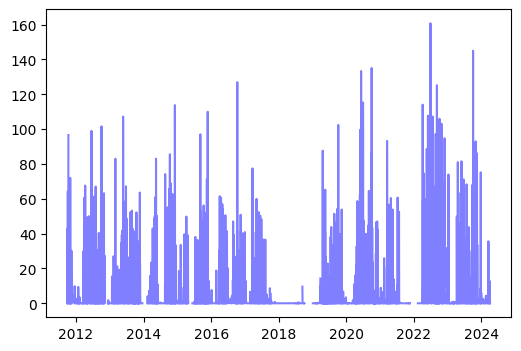

In [14]:
test = info_prec[info_prec['station']=='FEDEARROZ_SAN_MARTIN_EL_REPARO'].reset_index(drop=True)
test['date'] = pd.to_datetime(test['date'])

# Crear un rango continuo de fechas desde la fecha mínima hasta la máxima
date_range = pd.date_range(start=test['date'].min(), end=test['date'].max())

# Reindexar el DataFrame para asegurarse de que todas las fechas están presentes, y donde no haya datos poner NaN
test = test.set_index('date').reindex(date_range).reset_index()

# Renombrar la columna de fechas reindexadas
test = test.rename(columns={'index': 'date'})

plt.figure(figsize=(6, 4))


plt.plot(test['date'], test['precipitation'], label='Observed Precipitation', color='blue', alpha=0.5)


# Mostrar la gráfica
plt.show()

In [15]:
len(test[test['date'] > pd.to_datetime('2024-06-12')])

1350

Aunque la serie se ve bien hay muchos registros a futuro ... se escala el hallazgo y se decide quitar esta estacion

In [16]:
info_prec = info_prec[info_prec['station']!='FEDEARROZ_SAN_MARTIN_EL_REPARO'].reset_index(drop=True)


## Eventos (umbral 0.2)

In [17]:
info_prec['evento_lluvia'] = np.where(info_prec['precipitation'].isna(), np.nan, 
                                      np.where(info_prec['precipitation'] <= 0.2, 0, 1))
info_prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157831 entries, 0 to 157830
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   lat            157831 non-null  float64       
 1   lon            157831 non-null  float64       
 2   dpto           157831 non-null  object        
 3   mun            157831 non-null  object        
 4   date           157831 non-null  datetime64[ns]
 5   precipitation  134078 non-null  float64       
 6   station        157831 non-null  object        
 7   evento_lluvia  134078 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 9.6+ MB


### save info

In [20]:
info_prec['dpto'].unique()

array(['META', 'CESAR', 'BOLIVAR', 'CASANARE', 'HUILA', 'TOLIMA',
       'NORTE DE SANTANDER', 'MAGDALENA', 'GUAJIRA', 'CORDOBA',
       'ANTIOQUIA', 'NORTE DE SANTNADER'], dtype=object)

In [21]:
info_prec['dpto'] = info_prec['dpto'].replace('NORTE DE SANTNADER', 'NORTE DE SANTANDER')

In [22]:
info_prec.to_parquet('data/fedearroz_prec_diaria_2024.parquet')